In [ ]:
pip install krippendorff

In [ ]:
import pandas as pd
import numpy as np

import krippendorff
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import spacy
from textblob import TextBlob
import re
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize

from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from joblib import dump
from joblib import load
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.calibration import CalibratedClassifierCV

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
train_data = pd.read_csv("a3_train_final.tsv", sep='\t', header=None, names=['annotation', 'comment']).dropna()
test_data = pd.read_csv("a3_test.tsv", sep='\t', header=None, names=['annotation', 'comment']).dropna()

In [ ]:
def preprocess_comment(comment):
    comment = comment.lower() # Lowercase
    # deconcatinate words
    comment = re.sub(r"let\'s", "let us", comment)
    comment = re.sub(r"o\'clock", "of the clock", comment)
    comment = re.sub(r"ma\'am", "madam", comment)
    comment = re.sub(r"n\'t", " not", comment)
    comment = re.sub(r"\'re", " are", comment)
    comment = re.sub(r"\'s", " is", comment)
    comment = re.sub(r"\'d", " would", comment)
    comment = re.sub(r"\'ll", " will", comment)
    comment = re.sub(r"\'ve", " have", comment)
    comment = re.sub(r"\'m", " am", comment)
    comment = re.sub(r"ain\'t", "is not", comment)
    comment = re.sub(r"y\'all", "you all", comment)
    comment = re.sub(r"gonna", "going to", comment)
    comment = re.sub(r"wanna", "want to", comment)
    comment = re.sub(r"gotta", "got to", comment)

    # remove all emojis
    emojis = re.compile(
        "["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U000024C2-\U0001F251"
        u"\U00002702-\U000027B0"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", flags = re.UNICODE
      )
    comment = emojis.sub(r"", comment)

    comment = re.sub(r'http\S+|www\S+|https\S+', '', comment, flags=re.MULTILINE) # Remove URLs
    comment = re.sub(r'\W+|\d+', ' ', comment) # Remove special characters and digits
    comment = re.sub(r"@[\w]+", '', comment)  # Remove social media mentions more simply
    comment = re.sub(r"\brt\b", '', comment, flags=re.IGNORECASE)  # Remove RT markers, case-insensitive
    comment = re.sub(r'\s+', ' ', comment).strip() #Substitute multiple spaces with single space
    tokens = word_tokenize(comment) # Tokenization
    lemmatizer = WordNetLemmatizer() # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in set(stopwords.words('english')) and len(word) > 1]
    return ' '.join(tokens)

In [ ]:
# Apply preprocessing to the dataset
train_data['processed_comment'] = train_data['comment'].apply(preprocess_comment)
test_data['processed_comment'] = test_data['comment'].apply(preprocess_comment)

In [ ]:
# Calculate the frequency of each annotation
annotation_counts = train_data["annotation"].value_counts()

# Filter annotations that appear 100 times or more
annotations_to_keep = annotation_counts[annotation_counts >= 100].index.tolist()

# Filter the original DataFrame to keep only rows with the selected annotations
filtered_train_data = train_data[train_data["annotation"].isin(annotations_to_keep)]

reliability_data = filtered_train_data.copy()

In [ ]:
filtered_train_data

,annotation,comment,processed_comment
0,1/1,I'll only consume if I know what's inside it....,consume know inside still drinking monster tau...
1,0/-1,It is easier to fool a million people than it...,easier fool million people convince million pe...
2,0/0,NATURAL IMMUNITY protected us since evolutio...,natural immunity protected u since evolution e...
3,0/-1,NATURAL IMMUNITY protected us since evolutio...,natural immunity protected u since evolution e...
4,0/0,"Proud to have resisted. Proud of my husband, ...",proud resisted proud husband mother family pro...
...,...,...,...
50063,0/0,🤣 keep your 💩 I already know 3 people who have...,keep already know people hospitalized
50064,0/0,"🤣🤣🤣 ""JUST BECAUSE IT'S SAFE, DOESN'T MEAN IT D...",safe mean cause soreness pain death unlike bic...
50065,0/0,🤣🤣🤣 I took the Vaccine because of work. If I d...,took vaccine work laugh going cry
50066,0/0,🤨there's people already having severe side eff...,people already severe side effect bell palsy n...


In [ ]:
max_annotators = reliability_data['annotation'].apply(lambda x: len(x.split('/'))).max()
annotation_cols = ['annotation_' + str(i) for i in range(max_annotators)]
reliability_data[annotation_cols] = reliability_data['annotation'].str.split('/', expand=True)

# Convert annotations to numerical format
# Assuming annotations are already in '-1', '0', '1' format, if not convert them
reliability_data[annotation_cols] = reliability_data[annotation_cols].apply(pd.to_numeric, errors='coerce')


# Prepare reliability data for Krippendorff's Alpha
reliability_data = reliability_data[annotation_cols].to_numpy().T  # Transpose to match expected format

In [ ]:
# Calculate Krippendorff's Alpha for nominal data
alpha_nominal = krippendorff.alpha(reliability_data=reliability_data, level_of_measurement='nominal')
print(f"Krippendorff's Alpha (Nominal): {alpha_nominal}")

Krippendorff's Alpha (Nominal): 0.7309249932842664


In [ ]:
def simplify_annotation(value):
    simplified_annotation = []
    for annotation in value['annotation']:
        # Convert annotation to a string and split
        parts = str(annotation).split('/')
        counts = {1: 0, 0: 0, -1: 0}

        # Count occurrences of each sentiment
        for part in parts:
            if part in ['1', '0', '-1']:
                counts[int(part)] += 1

        # Determine the majority sentiment
        majority_sentiment = max(counts, key=lambda key: counts[key])

        # If there's a tie, this logic defaults to -1
        max_count = counts[majority_sentiment]
        if list(counts.values()).count(max_count) > 1:
            simplified_annotation.append(-1)  # Handling ties by defaulting to -1
        else:
            simplified_annotation.append(majority_sentiment)

    return simplified_annotation


In [ ]:
filtered_train_data = filtered_train_data.copy()
# Apply the function to the DataFrame and create a new column with the simplified annotations.
filtered_train_data.loc[:, 'simplified_annotation'] = simplify_annotation(filtered_train_data)

In [ ]:
filtered_train_data

,annotation,comment,processed_comment,simplified_annotation
0,1/1,I'll only consume if I know what's inside it....,consume know inside still drinking monster tau...,1
1,0/-1,It is easier to fool a million people than it...,easier fool million people convince million pe...,-1
2,0/0,NATURAL IMMUNITY protected us since evolutio...,natural immunity protected u since evolution e...,0
3,0/-1,NATURAL IMMUNITY protected us since evolutio...,natural immunity protected u since evolution e...,-1
4,0/0,"Proud to have resisted. Proud of my husband, ...",proud resisted proud husband mother family pro...,0
...,...,...,...,...
50063,0/0,🤣 keep your 💩 I already know 3 people who have...,keep already know people hospitalized,0
50064,0/0,"🤣🤣🤣 ""JUST BECAUSE IT'S SAFE, DOESN'T MEAN IT D...",safe mean cause soreness pain death unlike bic...,0
50065,0/0,🤣🤣🤣 I took the Vaccine because of work. If I d...,took vaccine work laugh going cry,0
50066,0/0,🤨there's people already having severe side eff...,people already severe side effect bell palsy n...,0


In [ ]:
filtered_train_data_2 = filtered_train_data.drop(filtered_train_data[filtered_train_data["simplified_annotation"] == -1].index)

In [ ]:
t_data = filtered_train_data_2.copy()

In [ ]:
t_data

,annotation,comment,processed_comment,simplified_annotation
0,1/1,I'll only consume if I know what's inside it....,consume know inside still drinking monster tau...,1
2,0/0,NATURAL IMMUNITY protected us since evolutio...,natural immunity protected u since evolution e...,0
4,0/0,"Proud to have resisted. Proud of my husband, ...",proud resisted proud husband mother family pro...,0
7,1/1,Vaccine takes more than a year to develop. T...,vaccine take year develop mistake people makin...,1
8,0/0,YES IM A TRUCKER FROM USA AND I WONT GET VACC...,yes im trucker usa wont get vaccinated get ret...,0
...,...,...,...,...
50063,0/0,🤣 keep your 💩 I already know 3 people who have...,keep already know people hospitalized,0
50064,0/0,"🤣🤣🤣 ""JUST BECAUSE IT'S SAFE, DOESN'T MEAN IT D...",safe mean cause soreness pain death unlike bic...,0
50065,0/0,🤣🤣🤣 I took the Vaccine because of work. If I d...,took vaccine work laugh going cry,0
50066,0/0,🤨there's people already having severe side eff...,people already severe side effect bell palsy n...,0


In [ ]:
# set X_train, Y_train, X_test and Y_test
X_train = t_data["processed_comment"]
Y_train = t_data["simplified_annotation"]
X_test = test_data["processed_comment"]
Y_test = test_data["annotation"]

In [ ]:
# create tf-idf with Dummy Classifier
pipeline_dc = make_pipeline(TfidfVectorizer(binary = True), DummyClassifier())
# fit the pipeline
pipeline_dc.fit(X_train, Y_train)
# get the prediction
Y_pred = pipeline_dc.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {accuracy:.4f}')
# view the classification report
print(classification_report(Y_test, Y_pred, target_names = ["Positive", "Negative"], zero_division=1))

Accuracy: 0.4998
              precision    recall  f1-score   support

    Positive       1.00      0.00      0.00      1020
    Negative       0.50      1.00      0.67      1019

    accuracy                           0.50      2039
   macro avg       0.75      0.50      0.33      2039
weighted avg       0.75      0.50      0.33      2039



In [ ]:
# create tf-idf with Logistic Regression
pipeline_lr = make_pipeline(TfidfVectorizer(binary = True), LogisticRegression(C=1, max_iter=100))
# fit the pipeline
pipeline_lr.fit(X_train, Y_train)
# get the prediction
Y_pred = pipeline_lr.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {accuracy:.4f}')
# view the classification report
print(classification_report(Y_test, Y_pred, target_names = ["Positive", "Negative"]))

Accuracy: 0.8391
              precision    recall  f1-score   support

    Positive       0.84      0.84      0.84      1020
    Negative       0.84      0.84      0.84      1019

    accuracy                           0.84      2039
   macro avg       0.84      0.84      0.84      2039
weighted avg       0.84      0.84      0.84      2039



In [ ]:
# create tf-idf with Bernoulli naive bayes
pipeline_bnb = make_pipeline(TfidfVectorizer(), BernoulliNB())
# fit the pipeline
pipeline_bnb.fit(X_train, Y_train)
# get the prediction
Y_pred = pipeline_bnb.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {accuracy:.4f}')
# view the classification report
print(classification_report(Y_test, Y_pred, target_names = ["Positive", "Negative"]))

Accuracy: 0.8328
              precision    recall  f1-score   support

    Positive       0.82      0.85      0.84      1020
    Negative       0.85      0.81      0.83      1019

    accuracy                           0.83      2039
   macro avg       0.83      0.83      0.83      2039
weighted avg       0.83      0.83      0.83      2039



In [ ]:
# create tf-idf with Multinomial naive bayes
pipeline_mnb = make_pipeline(TfidfVectorizer(),  MultinomialNB())
# fit the pipeline
pipeline_mnb.fit(X_train, Y_train)
# get the prediction
Y_pred = pipeline_mnb.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {accuracy:.4f}')
# view the classification report
print(classification_report(Y_test, Y_pred, target_names = ["Positive", "Negative"]))

Accuracy: 0.8333
              precision    recall  f1-score   support

    Positive       0.86      0.80      0.83      1020
    Negative       0.81      0.87      0.84      1019

    accuracy                           0.83      2039
   macro avg       0.84      0.83      0.83      2039
weighted avg       0.84      0.83      0.83      2039



In [ ]:
# create tf-idf with Linear SVC
pipeline_svc = make_pipeline(TfidfVectorizer(), LinearSVC(random_state = 0))
# fit the pipeline
pipeline_svc.fit(X_train, Y_train)
# get the prediction
Y_pred = pipeline_svc.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(Y_test, Y_pred)
print(f'Accuracy: {accuracy:.4f}')
# view the classification report
print(classification_report(Y_test, Y_pred, target_names = ["Positive", "Negative"]))

Accuracy: 0.8367
              precision    recall  f1-score   support

    Positive       0.84      0.83      0.84      1020
    Negative       0.83      0.84      0.84      1019

    accuracy                           0.84      2039
   macro avg       0.84      0.84      0.84      2039
weighted avg       0.84      0.84      0.84      2039



In [ ]:
#all models for GridSearch #hyperparameters
all_models = [pipeline_lr, pipeline_bnb, pipeline_mnb, pipeline_svc]

#selecting parameters
param_grid_logistic_regression = {
    'logisticregression__C': [1, 10, 100],  # Inverse of regularization strength
    'logisticregression__max_iter': [100, 200],  # Increasing number of iterations
    'logisticregression__solver': ['lbfgs','saga']  # Algorithm to use for optimization
}

param_grid_bernoulli = {
    'bernoullinb__alpha': [0.01, 0.1, 1.0],  # Additive (Laplace/Lidstone) smoothing parameter
    'bernoullinb__fit_prior': [True, False]
}

param_grid_multinomial = {
    'multinomialnb__alpha': [0.1, 0.5, 1.0],  # Additive (Laplace/Lidstone) smoothing parameter for MultinomialNB
    'multinomialnb__fit_prior': [True, False]
}

param_grid_svc = {
    'linearsvc__C': [1.0, 10.0, 100.0],  # Regularization parameter
    'linearsvc__dual': [True, False],
    'linearsvc__random_state': [0]  # Keeping the random state fixed
}


#list of all parameters
param_grid_list = [param_grid_logistic_regression, param_grid_bernoulli, param_grid_multinomial, param_grid_svc]

# List to hold the best classifier, its score, and parameters for each model
best_clf_info = {
    "best_clf": None,
    "best_score": -1,
    "best_params": None,
    "best_pipeline": ""
}

# Dictionary to hold the performance of each model
model_performance = {}

# Iterate over each pipeline and its corresponding parameters
for pipeline, params in zip(all_models, param_grid_list):
    print(f"Testing parameters for {pipeline.steps[-1][0]}")

    # Create and fit the GridSearchCV
    grid = GridSearchCV(estimator=pipeline, param_grid=params, cv=5, scoring="roc_auc", n_jobs=-1, verbose=0)
    grid.fit(X_train, Y_train)

    # Check if this model has the best score so far
    if grid.best_score_ > best_clf_info["best_score"]:
        best_clf_info["best_clf"] = grid.best_estimator_
        best_clf_info["best_score"] = grid.best_score_
        best_clf_info["best_params"] = grid.best_params_
        best_clf_info["best_pipeline"] = pipeline.steps[-1][0]

    # Print the best parameters and score for this model
    print("Best parameters set found on development set:")
    print(grid.best_estimator_.steps)
    print("Best score: {:.4f}".format(grid.best_score_))

    # Predict on the test set using the best found parameters for this model
    y_pred = grid.predict(X_test)


    # Calculate and print the accuracy and classification report
    accuracy = accuracy_score(Y_test, y_pred)
    print(f"Accuracy for {pipeline.steps[-1][0]}: {accuracy:.4f}")
    print(classification_report(Y_test, y_pred, target_names=["Negative", "Positive"]))
    print("------------------------------------------\n")

     # Store ROC AUC and Accuracy in the model_performance dictionary
    model_performance[pipeline.steps[-1][0]] = {
        'ROC AUC': grid.best_score_,
        'Accuracy': accuracy
    }

# After the loop, print out the information about the best classifier overall
print("Best Classifier Across All Models:")
print(best_clf_info["best_pipeline"])
print("Best score across all models: {:.4f}".format(best_clf_info["best_score"]))
print("Best parameters across all models:")
print(best_clf_info["best_params"])

Testing parameters for logisticregression
Best parameters set found on development set:
[('tfidfvectorizer', TfidfVectorizer(binary=True)), ('logisticregression', LogisticRegression(C=1, solver='saga'))]
Best score: 0.8934
Accuracy for logisticregression: 0.8391
              precision    recall  f1-score   support

    Negative       0.84      0.84      0.84      1020
    Positive       0.84      0.84      0.84      1019

    accuracy                           0.84      2039
   macro avg       0.84      0.84      0.84      2039
weighted avg       0.84      0.84      0.84      2039

------------------------------------------

Testing parameters for bernoullinb
Best parameters set found on development set:
[('tfidfvectorizer', TfidfVectorizer()), ('bernoullinb', BernoulliNB())]
Best score: 0.8875
Accuracy for bernoullinb: 0.8328
              precision    recall  f1-score   support

    Negative       0.82      0.85      0.84      1020
    Positive       0.85      0.81      0.83      10

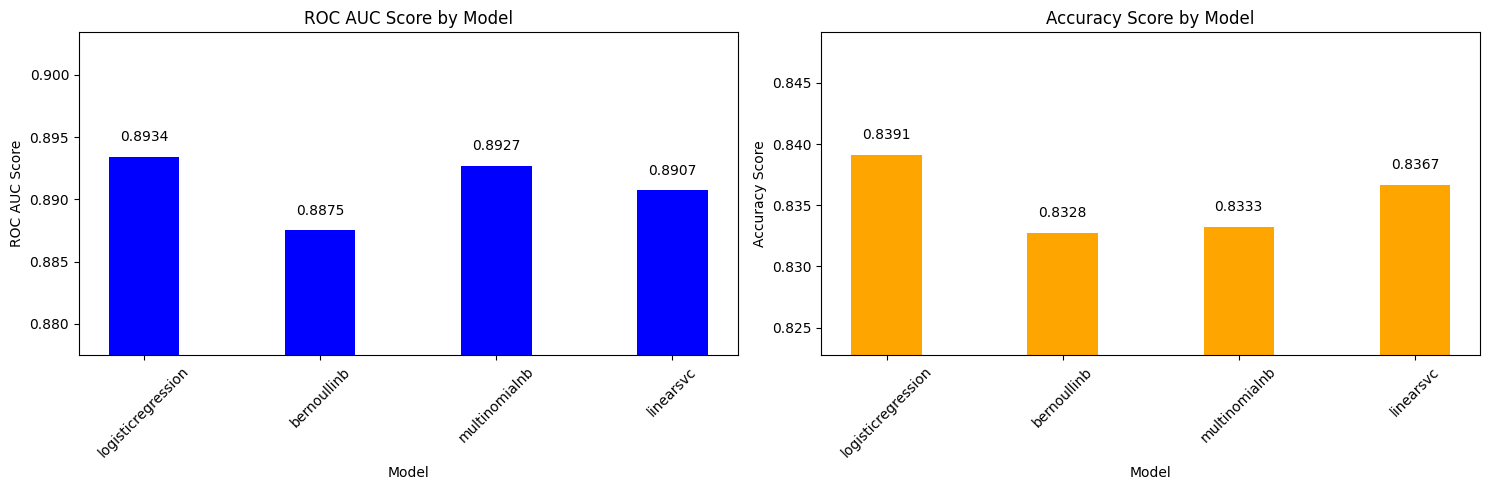

In [ ]:
# After the loop, plot the ROC AUC and Accuracy for each model
# Extracting the ROC AUC and Accuracy scores from 'model_performance'
roc_aucs = [model_performance[model]['ROC AUC'] for model in model_performance]
accuracies = [model_performance[model]['Accuracy'] for model in model_performance]
model_names = list(model_performance.keys())

# Setting the positions for the bars
positions = range(len(model_performance))

# Creating the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plotting ROC AUC scores
axes[0].bar(positions, roc_aucs, color='blue', width=0.4)
axes[0].set_xticks(positions)
axes[0].set_xticklabels(model_names, rotation=45)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('ROC AUC Score')
axes[0].set_title('ROC AUC Score by Model')
# Setting y-axis limits to the range of ROC AUC scores plus some padding
axes[0].set_ylim([min(roc_aucs) - 0.01, max(roc_aucs) + 0.01])

# Adding data labels above the bars for ROC AUC scores
for i, score in enumerate(roc_aucs):
    axes[0].text(i, score + 0.001, f'{score:.4f}', ha='center', va='bottom')

# Plotting Accuracy scores
axes[1].bar(positions, accuracies, color='orange', width=0.4)
axes[1].set_xticks(positions)
axes[1].set_xticklabels(model_names, rotation=45)
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Accuracy Score')
axes[1].set_title('Accuracy Score by Model')
# Setting y-axis limits to the range of accuracy scores plus some padding
axes[1].set_ylim([min(accuracies) - 0.01, max(accuracies) + 0.01])

# Adding data labels above the bars for accuracy scores
for i, score in enumerate(accuracies):
    axes[1].text(i, score + 0.001, f'{score:.4f}', ha='center', va='bottom')

# Adjusting layout and displaying the plot
plt.tight_layout()
plt.show()

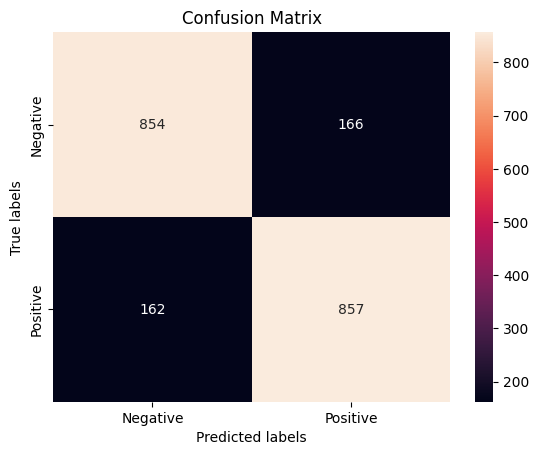

In [ ]:
Y_pred = pipeline_lr.predict(X_test)
cm = confusion_matrix(Y_test, Y_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt='g')

# Labels, title, and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
plt.show()

In [ ]:
# Predict the probability scores for the positive class
Y_prob = pipeline_dc.predict_proba(X_test)[:, 1] # get the probability of the positive class
# Calculate the AUC score
auc_score_dc = roc_auc_score(Y_test, Y_prob)
print(f'Dummy Classifier AUC Score: {auc_score_dc:.3f}')

# Predict the probability scores for the positive class
Y_prob = pipeline_lr.predict_proba(X_test)[:, 1] # get the probability of the positive class
# Calculate the AUC score
auc_score_lr = roc_auc_score(Y_test, Y_prob)
print(f'Linear Regression AUC Score: {auc_score_lr:.3f}')

# Predict the probability scores for the positive class
Y_prob = pipeline_bnb.predict_proba(X_test)[:, 1] # get the probability of the positive class
# Calculate the AUC score
auc_score_bnb = roc_auc_score(Y_test, Y_prob)
print(f'Bernoulli NB AUC Score: {auc_score_bnb:.3f}')

# Predict the probability scores for the positive class
Y_prob = pipeline_mnb.predict_proba(X_test)[:, 1] # get the probability of the positive class
# Calculate the AUC score
auc_score_mnb = roc_auc_score(Y_test, Y_prob)
print(f'Multinomial NB AUC Score: {auc_score_mnb:.3f}')

# Create a LinearSVC model
svc = LinearSVC(random_state=0)

# Calibrate the model on the outputs
calibrated_svc = CalibratedClassifierCV(svc, method='sigmoid', cv='prefit')

# Include the calibrated model in the pipeline
pipeline_svc_calibrated = make_pipeline(
    TfidfVectorizer(),
    calibrated_svc
)

# Fit the pipeline on the training data
# Fitting the LinearSVC before fitting CalibratedClassifierCV in the pipeline
X_train_transformed = TfidfVectorizer().fit_transform(X_train)
svc.fit(X_train_transformed, Y_train)

# Fitting the calibrated model in the pipeline
pipeline_svc_calibrated.fit(X_train, Y_train)

# Predict the probability scores for the positive class
Y_prob = pipeline_svc_calibrated.predict_proba(X_test)[:, 1]

# Calculate the AUC score
auc_score_svc = roc_auc_score(Y_test, Y_prob)
print(f'Linear SVC AUC Score: {auc_score_svc:.3f}')

Dummy Classifier AUC Score: 0.500
Linear Regression AUC Score: 0.923
Bernoulli NB AUC Score: 0.913
Multinomial NB AUC Score: 0.916
Linear SVC AUC Score: 0.921


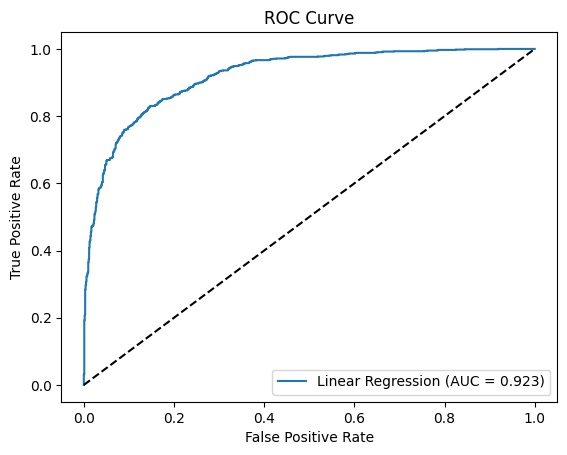

In [ ]:
#Plot the ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, Y_prob)
plt.plot(fpr, tpr, label=f'Linear Regression (AUC = {auc_score_lr:.3f})')
plt.plot([0, 1], [0, 1], 'k--')  # dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [ ]:
# Save the trained pipeline to disk
dump(pipeline_lr, 'pipeline_lr.joblib')

['pipeline_lr.joblib']

In [ ]:
# Load spaCy's English language model
nlp = spacy.load("en_core_web_sm")

rf_model = load('pipeline_lr.joblib')

# Function to extract aspects using noun phrases
def extract_relevant_aspects(text):
    doc = nlp(text)
    aspects = []

    # Combine NER and noun chunks for aspect extraction
    named_entities = set(ent.text for ent in doc.ents)
    for chunk in doc.noun_chunks:
        if chunk.root.pos_ in ['NOUN', 'PROPN']:  # Focusing on nouns and proper nouns
            if chunk.text not in named_entities:  # Avoid duplicating NER
                aspects.append(chunk.text)
    aspects.extend(named_entities)
    return aspects

# Function to predict sentiment for extracted aspects
def predict_aspect_sentiment(text, model):
    aspects = extract_relevant_aspects(text)
    aspect_sentiments = {}
    for aspect in aspects:
        # Preprocess the aspect text similarly to how comments were preprocessed
        processed_aspect = preprocess_comment(aspect)
        sentiment_prediction = model.predict([processed_aspect])[0]
        aspect_sentiments[aspect] = 'Positive' if sentiment_prediction == 1 else 'Negative'
    return aspect_sentiments

# Function to apply ABSA over a DataFrame and add results to a new column
def apply_absa_to_dataframe(dataframe, model):
    dataframe['aspect_sentiments'] = dataframe['processed_comment'].apply(lambda x: predict_aspect_sentiment(x, model))
    return dataframe

# Apply ABSA to the train and test datasets
train_data_with_absa = apply_absa_to_dataframe(t_data, rf_model)
test_data_with_absa = apply_absa_to_dataframe(test_data, rf_model)

# view the results
print(train_data_with_absa[['processed_comment', 'aspect_sentiments']].head())
print(test_data_with_absa[['processed_comment', 'aspect_sentiments']].head())

                                   processed_comment  \
0  consume know inside still drinking monster tau...   
2  natural immunity protected u since evolution e...   
4  proud resisted proud husband mother family pro...   
7  vaccine take year develop mistake people makin...   
8  yes im trucker usa wont get vaccinated get ret...   

                                   aspect_sentiments  
0     {'monster': 'Negative', 'taurine': 'Negative'}  
2  {'natural immunity': 'Negative', 'u': 'Negativ...  
4  {'proud': 'Negative', 'proud husband mother fa...  
7  {'vaccine': 'Positive', 'mistake people': 'Neg...  
8  {'trucker usa': 'Negative', 'ottawa': 'Negativ...  
                                   processed_comment  \
0  tell body people want enforce anti abortion la...   
1  research mean looked online already believed a...   
2  know know hamburger eat milk drink high fructo...   
3   trust immune system translates know vaccine work   
4  september time frame unvaccinated people time ... 

In [ ]:
aspect_data = t_data.copy()
aspect_data

,annotation,comment,processed_comment,simplified_annotation,aspect_sentiments
0,1/1,I'll only consume if I know what's inside it....,consume know inside still drinking monster tau...,1,"{'monster': 'Negative', 'taurine': 'Negative'}"
2,0/0,NATURAL IMMUNITY protected us since evolutio...,natural immunity protected u since evolution e...,0,"{'natural immunity': 'Negative', 'u': 'Negativ..."
4,0/0,"Proud to have resisted. Proud of my husband, ...",proud resisted proud husband mother family pro...,0,"{'proud': 'Negative', 'proud husband mother fa..."
7,1/1,Vaccine takes more than a year to develop. T...,vaccine take year develop mistake people makin...,1,"{'vaccine': 'Positive', 'mistake people': 'Neg..."
8,0/0,YES IM A TRUCKER FROM USA AND I WONT GET VACC...,yes im trucker usa wont get vaccinated get ret...,0,"{'trucker usa': 'Negative', 'ottawa': 'Negativ..."
...,...,...,...,...,...
50063,0/0,🤣 keep your 💩 I already know 3 people who have...,keep already know people hospitalized,0,{'people': 'Positive'}
50064,0/0,"🤣🤣🤣 ""JUST BECAUSE IT'S SAFE, DOESN'T MEAN IT D...",safe mean cause soreness pain death unlike bic...,0,"{'soreness pain death': 'Positive', 'biceps': ..."
50065,0/0,🤣🤣🤣 I took the Vaccine because of work. If I d...,took vaccine work laugh going cry,0,{'cry': 'Positive'}
50066,0/0,🤨there's people already having severe side eff...,people already severe side effect bell palsy n...,0,"{'people': 'Positive', 'already severe side ef..."


In [ ]:
# Filter out any empty strings post-preprocessing
aspect_data = aspect_data[aspect_data['processed_comment'].str.strip() != ""]

# Initialize TF-IDF Vectorizer with a minimal stop word list to avoid empty vocabulary
vectorizer = TfidfVectorizer(max_features=1000, stop_words=None)

# Vectorize the processed comments
X = vectorizer.fit_transform(aspect_data['processed_comment'])

# Initialize and fit the NMF model
nmf = NMF(n_components=20, random_state=42)
W = nmf.fit_transform(X)
H = nmf.components_

# Extract feature names and top words for each topic
feature_names = vectorizer.get_feature_names_out()
top_words = 20
for i, topic in enumerate(H):
    print(f"Keywords {i}:")
    top_feature_indices = topic.argsort()[-top_words:][::-1]  # Reverse to get largest first
    print(" ".join([feature_names[index] for index in top_feature_indices]))

Keywords 0:
vaccine work mrna pandemic disease death thank believe pro virus thanks cause dangerous new pfizer available kill world experimental safety
Keywords 1:
get shot go wait going sick please soon back everyone booster let ca able hope reason wo stay mine excited
Keywords 2:
got shot first dose second today pfizer day moderna booster week feel arm yesterday ago fine sore two feeling happy
Keywords 3:
take chance going shot poison would please wo dont rather care everyone risk refuse let force forced responsibility job reason
Keywords 4:
people many died dying killing think unvaccinated die lot believe million know kill understand stop death see young ca sick
Keywords 5:
effect side long term death serious know risk pfizer rare arm unknown potential far many adverse affect zero sore possible
Keywords 6:
covid death risk still flu booster died die prevent unvaccinated symptom infection dying chance patient effective worse severe case fight
Keywords 7:
vaccinated fully protect fami

In [ ]:
# Define a set of irrelevant or generic terms to exclude
irrelevant_terms = {"anti vaxxers", "next day", "risk",  "vaccination", "last week", "family", "disease", "work", "parent", "child", "american", "body", "thing", "vax", "day", "year old", "chance", "year", "month", "today", "hour", "yesterday", "tomorrow", "week", "people", "something", "anything", "everything", "everyone", "life", "world",
                     "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj",
                     "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't","all",
                    "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount",
                    "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "apart",
                    "apparently", "appear", "appreciate", "appropriate", "approximately", "are", "aren", "arent", "aren't", "arise", "around", "as",
                    "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "back", "bc", "bd", "be", "became", "because",
                    "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below",
                    "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "both", "bottom", "bp", "br", "brief",
                    "briefly", "but", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes",
                    "certain", "certainly", "changes", "clearly", "covid","pfizer vaccine", "covid vaccine", "vaccine", "c'mon", "co", "com", "come", "comes", "con",
                    "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't",
                    "course", "cry", "cs", "ct", "currently", "cv", "cz", "da", "date", "dc", "de", "definitely", "describe", "described", "despite", "detail",
                    "di", "did", "didn", "didn't", "different", "dj", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp",
                    "due", "during", "each", "ed", "edu", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end",
                    "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone",
                    "everything", "everywhere", "ex", "exactly", "example", "except", "far", "few", "fifteen", "fifth", "fify", "fill", "find",
                    "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four",
                    "from", "front", "full", "further", "furthermore", "gave", "ge", "get", "gets", "getting", "give", "given", "gives", "giving",
                    "go", "goes", "going", "gone", "got", "gotten", "greetings", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't",
                    "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes",
                    "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred",
                    "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ignored", "il", "i'll", "im", "i'm", "immediate", "immediately",
                    "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest",
                    "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "just", "k",
                    "keep", "keeps", "kept", "kg", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "least", "les", "less",
                    "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "look", "looking", "looks",
                    "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "many people",
                    "mightn't", "mill", "million", "mine", "miss", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn",
                    "mustn't", "my", "myself", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs",
                    "neither", "never", "nevertheless", "new", "next", "nine", "ninety", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally",
                    "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often",
                    "oh", "oi", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other",
                    "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3",
                    "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl",
                    "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pr", "predominantly", "present", "presumably", "previously",
                    "primarily", "probably", "promptly", "proud", "provides", "put", "quickly", "quite", "ran",
                    "rather", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively",
                    "research", "research-articl", "respectively", "resulted", "resulting", "results", "right", "rj",
                    "run", "sa", "said", "same", "saw", "say", "saying", "says", "sec", "second", "secondly", "section", "see", "seeing",
                    "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't",
                    "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side",
                    "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow",
                    "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying",
                    "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure","system",
                     "take", "taken", "taking", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that",
                    "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore",
                    "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're",
                    "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through",
                    "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried",
                    "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "u", "uk", "um", "un", "under",
                    "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness",
                    "uses", "using", "usually",  "value", "various", "very", "via", "viz", "vol", "vols", "volumtype",
                    "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren",
                    "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby",
                    "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever",
                    "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "won", "wonder", "wont", "won't", "words",
                    "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "zero"}

In [ ]:
# Initialize counters for positive and negative sentiments
positive_aspects = Counter()
negative_aspects = Counter()

# Iterate over the aspect sentiments in the dataset
for index, row in train_data_with_absa.iterrows():
    for aspect, sentiment in row['aspect_sentiments'].items():
      # Check if the aspect is not in the set of irrelevant terms
        if aspect.lower() not in irrelevant_terms:
            if sentiment == 'Positive':
                positive_aspects[aspect] += 1
            else:
                negative_aspects[aspect] += 1

# Display the most common positive and negative aspects after excluding irrelevant terms
print("Most common positive aspects after excluding irrelevant terms:")
print(positive_aspects.most_common(10))

print("\nMost common negative aspects after excluding irrelevant terms:")
print(negative_aspects.most_common(10))

Most common positive aspects after excluding irrelevant terms:
[('booster', 319), ('science', 194), ('moderna', 141), ('pfizer', 138), ('hope', 118), ('second dose', 114), ('vaccine work', 110), ('fact', 95), ('johnson johnson', 91), ('vaccinated people', 88)]

Most common negative aspects after excluding irrelevant terms:
[('god', 377), ('mrna', 365), ('virus', 359), ('side effect', 336), ('fda', 214), ('jab', 212), ('poison', 183), ('death', 177), ('immune system', 173), ('mask', 171)]


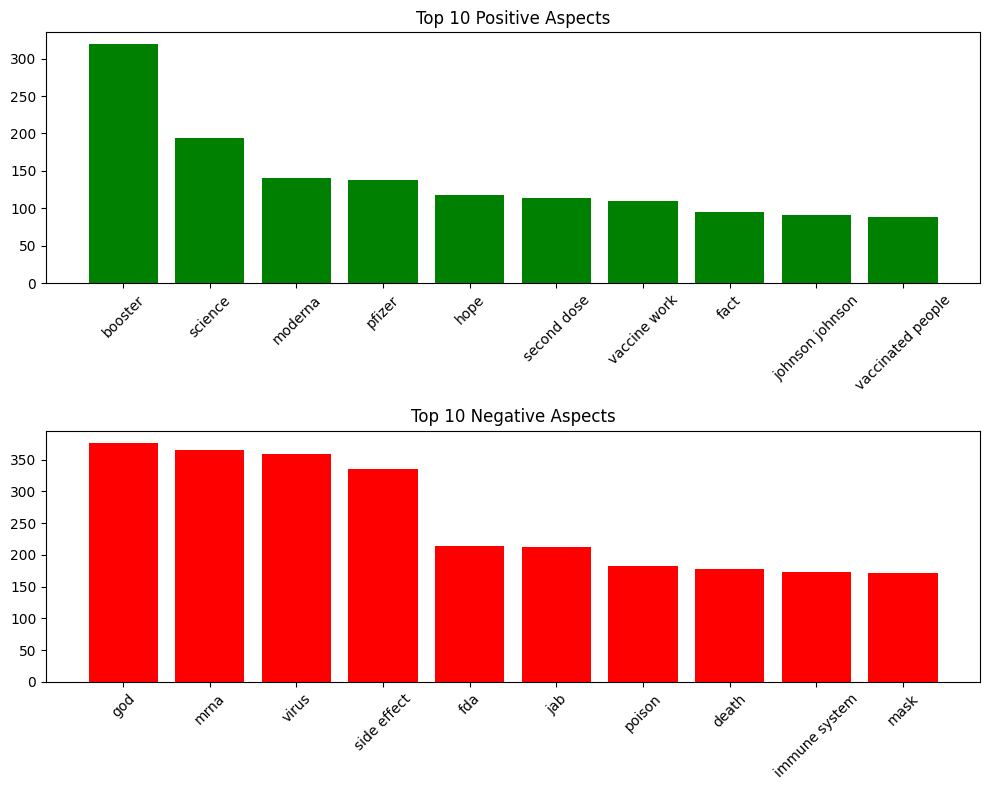

In [ ]:
# Get the top 10 negative and positive aspects for plotting
top_pos_aspects = positive_aspects.most_common(10)
top_neg_aspects = negative_aspects.most_common(10)

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

ax[0].bar([x[0] for x in top_pos_aspects], [x[1] for x in top_pos_aspects], color='green')
ax[0].set_title('Top 10 Positive Aspects')
ax[0].tick_params(axis='x', rotation=45)

ax[1].bar([x[0] for x in top_neg_aspects], [x[1] for x in top_neg_aspects], color='red')
ax[1].set_title('Top 10 Negative Aspects')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()